In [13]:
# import pandas as pd
# from pandas import read_excel
# import numpy as np
# import pandas as pd
# pd.options.mode.chained_assignment = None
# from datetime import date, datetime, timedelta, timezone
# import copy
# from pandas import IndexSlice as idx
# pd.set_option('display.max_columns', None)  # 当列太多时不换行
# from numpy import exp, nan
# import quantstats as qs
# import warnings
# warnings.filterwarnings('ignore') # 忽略警告
# import pandas as pd
# from pandas import IndexSlice as idx

# import talib as ta

In [158]:
import pandas as pd
import numpy as np
import quantstats as qs
import warnings
import itertools # Needed for generating combinations
from tqdm.auto import tqdm # Optional: for progress bar
import pandas as pd
import numpy as np
import quantstats as qs
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Functions from previous step (load_data, filter_data, calculate_scores) ---
# --- Assume they are defined exactly as in the previous answer ---

# --- Step 1: Load Data (Function remains the same) ---
def load_data(cb_path, index_path):
    """Loads convertible bond and index data."""
    print("--- Step 1: Loading Data ---")
    try:
        df = pd.read_parquet(cb_path)
        index_df = pd.read_parquet(index_path)
        if not isinstance(index_df.index, pd.DatetimeIndex):
            index_df.index = pd.to_datetime(index_df.index)
        if 'trade_date' in df.index.names:
            date_level_idx = df.index.names.index('trade_date')
            if not isinstance(df.index.levels[date_level_idx], pd.DatetimeIndex):
                df.index = df.index.set_levels(pd.to_datetime(df.index.levels[date_level_idx]), level='trade_date')
        else: # Try to set index if columns exist
             required_levels = ['code', 'trade_date']
             if all(col in df.columns for col in required_levels):
                 df['trade_date'] = pd.to_datetime(df['trade_date'])
                 df = df.set_index(required_levels)
             else: raise ValueError("Cannot set multi-index, missing columns.")
        print(f"Loaded CB data shape: {df.shape}, Index data shape: {index_df.shape}")
        return df, index_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

# --- Step 2: Filter Data (Function remains the same) ---
def filter_data(df, start_date, end_date, filter_rules):
    """Applies date range and custom filters."""
    print("--- Step 2: Filtering Data ---")
    if df is None: return None
    try:
        trade_date_level = df.index.get_level_values('trade_date')
        date_mask = (trade_date_level >= start_date) & (trade_date_level <= end_date)
        df_filtered = df[date_mask].copy()
        if df_filtered.empty: raise ValueError("No data remaining after date filtering.")
        print(f"Filtered by date: {start_date} to {end_date}. Shape: {df_filtered.shape}")
    except Exception as e:
        print(f"Error during date filtering: {e}")
        return None

    df_filtered['filter_out'] = False
    # Essential filters
    redeem_statuses = ['已公告强赎', '公告到期赎回', '公告实施强赎', '公告提示强赎', '已满足强赎条件']
    if 'is_call' in df_filtered.columns: df_filtered.loc[df_filtered['is_call'].isin(redeem_statuses), 'filter_out'] = True
    if 'list_days' in df_filtered.columns: df_filtered.loc[df_filtered['list_days'] <= 3, 'filter_out'] = True
    # Custom filters
    print("Applying custom filters...")
    for rule in filter_rules:
        try:
            matching_indices = df_filtered.query(rule).index
            df_filtered.loc[matching_indices, 'filter_out'] = True
        except Exception as e:
            print(f"  - Warning: Could not apply filter rule '{rule}'. Error: {e}")
    print(f"Filtering complete. Eligible bond-days: {len(df_filtered[~df_filtered['filter_out']])}")
    if len(df_filtered[~df_filtered['filter_out']]) == 0:
        print("Warning: No bonds eligible after applying all filters.")
    return df_filtered

# --- Step 3: Calculate Scores (Function remains the same) ---
# It takes a specific factor_weights dictionary for a single run
def calculate_scores(df, factor_weights):
    """Ranks factors, calculates weighted score for ONE combination of weights."""
    # print("--- Step 3: Calculating Scores ---") # Keep this less verbose in a loop
    if df is None or 'filter_out' not in df.columns: return None

    df_eligible = df[~df['filter_out']]
    if df_eligible.empty:
        df['final_score'] = np.nan
        df['final_rank'] = np.nan
        for factor in factor_weights.keys(): df[f"{factor}_rank"] = np.nan
        return df # Return df with NaNs

    df_scored = df.copy()
    df_scored['final_score'] = 0.0
    factors_used = list(factor_weights.keys())

    # # Feature Engineering (simplified: assumes features exist or are calculated)
    # if 'max_value_position' in factors_used and 'max_value_position' not in df_scored.columns:
    #     # print("Calculating 'max_value_position' feature...") # Less verbose
    #     df_scored['max_value'] = df_scored.groupby(level='code')['close'].cummax().shift(1)
    #     df_scored['max_value'] = df_scored['max_value'].replace(0, np.nan)
    #     df_scored['max_value_position'] = df_scored['close'] / df_scored['max_value']
    #     df_scored['max_value_position'] = df_scored['max_value_position'].fillna(1.0)
    #     df_scored['max_value_position'] = df_scored['max_value_position'].replace([np.inf, -np.inf], 1.0)

    # Rank factors and calculate score
    for factor in factors_used:
        if factor not in df_scored.columns:
            print(f"Warning: Factor '{factor}' not found. Skipping.")
            df_scored[f"{factor}_rank"] = np.nan
            continue
        weight = factor_weights[factor]
        rank_col_name = f"{factor}_rank"
        ranks = df_eligible.groupby(level='trade_date')[factor].rank(method='first', ascending=False)
        df_scored[rank_col_name] = ranks
        df_scored['final_score'] += df_scored[rank_col_name].fillna(0) * weight

    df_scored.loc[df_scored['filter_out'], 'final_score'] = np.nan
    df_scored['final_rank'] = df_scored.groupby(level='trade_date')['final_score'].rank(method='first', ascending=True)
    df_scored.loc[df_scored['filter_out'], 'final_rank'] = np.nan

    return df_scored


# --- Step 4: Modified Calculate Returns & Turnover ---
def calculate_strategy_performance(df_scored, hold_num, sp_pct, commission_rate):
    """
    Calculates net returns and average daily turnover rate for a single strategy run.
    Does NOT generate the full QS report.

    Args:
        df_scored (pd.DataFrame): DataFrame with 'final_rank'.
        hold_num (int): Number of bonds to hold.
        sp_pct (float): Stop-profit percentage.
        commission_rate (float): Commission rate.

    Returns:
        tuple: (pandas.Series: net_returns, float: avg_daily_turnover_rate)
               Returns (None, None) if calculation fails.
    """
    # print("--- Step 4: Calculating Performance ---") # Less verbose
    if df_scored is None or 'final_rank' not in df_scored.columns: return None, None

    # Prepare next-day data
    df_perf = df_scored.copy() # Work on a copy
    grouped = df_perf.groupby(level='code')
    df_perf['aft_open'] = grouped['open'].shift(-1)
    df_perf['aft_close'] = grouped['close'].shift(-1)
    df_perf['aft_high'] = grouped['high'].shift(-1)
    df_perf['time_return'] = grouped['pct_chg'].shift(-1)

    # Apply Stop-Profit
    sp_triggered_high = (df_perf['aft_high'] >= df_perf['close'] * (1 + sp_pct))
    sp_triggered_open = (df_perf['aft_open'] >= df_perf['close'] * (1 + sp_pct))
    df_perf.loc[sp_triggered_open, 'time_return'] = (df_perf['aft_open'] - df_perf['close']) / df_perf['close']
    df_perf.loc[sp_triggered_high & ~sp_triggered_open, 'time_return'] = sp_pct

    # Generate Signal
    df_perf['signal'] = np.where((df_perf['final_rank'] <= hold_num) & (~df_perf['final_rank'].isna()), 1, 0)

    # Calculate Portfolio Returns
    portfolio_df = df_perf[df_perf['signal'] == 1]
    if portfolio_df.empty:
        # print("Warning: No bonds selected for portfolio in this run.") # Less verbose
        return None, None # Indicate failure for this combo
    daily_returns = portfolio_df.groupby(level='trade_date')['time_return'].mean()

    # Calculate Costs & Turnover
    pos_df = df_perf['signal'].unstack(level='code', fill_value=0).astype(int)
    turnover = pos_df.diff().fillna(0).abs().sum(axis=1)
    prev_positions = pos_df.shift(1).sum(axis=1)
    curr_positions = pos_df.sum(axis=1)
    total_exposure_factor = prev_positions + curr_positions
    total_exposure_factor = total_exposure_factor.replace(0, np.nan) # Avoid division by zero

    daily_cost_pct = (turnover * commission_rate) / total_exposure_factor
    if not daily_cost_pct.empty and not pos_df.empty:
        daily_cost_pct.iloc[0] = 0.5 * commission_rate if curr_positions.iloc[0] > 0 else 0

    # Calculate Net Returns
    res = pd.DataFrame({'time_return': daily_returns}).fillna(0)
    res['cost'] = daily_cost_pct.reindex(res.index).fillna(0)
    res['net_return'] = (1 + res['time_return']) * (1 - res['cost']) - 1

    # Calculate Average Daily Turnover Rate
    # Turnover rate = daily trades / number of positions held that day
    # Avoid division by zero if no positions held
    daily_turnover_rate = (turnover / curr_positions.replace(0, np.nan)).fillna(0)
    avg_daily_turnover_rate = daily_turnover_rate.mean() if not daily_turnover_rate.empty else 0.0

    return res['net_return'], avg_daily_turnover_rate




# --- Assume other functions (load_data, filter_data, calculate_scores, calculate_strategy_performance) are defined above ---

# --- Corrected Function to Calculate Metrics ---
def get_performance_metrics(returns, benchmark_returns, avg_turnover):
    """Calculates specific performance metrics using QuantStats."""
    metrics = {}
    # Basic check for valid returns series
    if returns is None or not isinstance(returns, pd.Series) or returns.isnull().all() or len(returns) < 2:
        print("Warning: Insufficient or invalid return data for metric calculation.")
        # Return structure with NaNs, turnover might still be valid
        return {
             'Cumulative Return': np.nan, 'CAGR': np.nan, 'Sharpe': np.nan,
             'Prob. Sharpe Ratio': np.nan, 'Smart Sharpe': np.nan, 'Sortino': np.nan,
             'Max Drawdown': np.nan, 'Longest DD Days': np.nan, 'Volatility (ann.)': np.nan,
             'Information Ratio': np.nan, 'Beta': np.nan, 'Alpha': np.nan,
             'Avg Daily Turnover': avg_turnover if avg_turnover is not None else np.nan
        }

    # Proceed with calculations if returns are valid
    try:
        metrics['Cumulative Return'] = qs.stats.comp(returns)
    except Exception as e:
        print(f"Warning: Failed calculating Cumulative Return: {e}")
        metrics['Cumulative Return'] = np.nan

    try:
        metrics['CAGR'] = qs.stats.cagr(returns)
    except Exception as e:
        print(f"Warning: Failed calculating CAGR: {e}")
        metrics['CAGR'] = np.nan

    try:
        metrics['Sharpe'] = qs.stats.sharpe(returns)
    except Exception as e:
        print(f"Warning: Failed calculating Sharpe: {e}")
        metrics['Sharpe'] = np.nan

    try:
        metrics['Prob. Sharpe Ratio'] = qs.stats.probabilistic_sharpe_ratio(returns)
    except Exception as e:
        # This can fail if std dev is zero or very low
        # print(f"Warning: Failed calculating Prob. Sharpe Ratio: {e}") # Can be noisy
        metrics['Prob. Sharpe Ratio'] = np.nan

    try:
        metrics['Smart Sharpe'] = qs.stats.smart_sharpe(returns)
    except Exception as e:
        # print(f"Warning: Failed calculating Smart Sharpe: {e}") # Can be noisy
        metrics['Smart Sharpe'] = np.nan

    try:
        metrics['Sortino'] = qs.stats.sortino(returns)
    except Exception as e:
        print(f"Warning: Failed calculating Sortino: {e}")
        metrics['Sortino'] = np.nan

    try:
        metrics['Max Drawdown'] = qs.stats.max_drawdown(returns)
    except Exception as e:
        print(f"Warning: Failed calculating Max Drawdown: {e}")
        metrics['Max Drawdown'] = np.nan

    # --- Corrected Longest Drawdown Days Calculation ---
    try:
        dd_info = qs.stats.drawdown_details(returns)
        if dd_info is not None and not dd_info.empty and 'Days' in dd_info.columns:
            metrics['Longest DD Days'] = int(dd_info['Days'].max()) # Get max from 'Days' column
        elif dd_info is not None and dd_info.empty:
             metrics['Longest DD Days'] = 0 # No drawdowns found
        else:
             metrics['Longest DD Days'] = np.nan # Handle unexpected output
    except Exception as e:
        print(f"Warning: Could not calculate Longest DD Days. Error: {e}")
        metrics['Longest DD Days'] = np.nan
    # --- End of Correction ---

    try:
        metrics['Volatility (ann.)'] = qs.stats.volatility(returns)
    except Exception as e:
        print(f"Warning: Failed calculating Volatility: {e}")
        metrics['Volatility (ann.)'] = np.nan

    # Benchmark-related metrics
    # Check benchmark validity more carefully
    is_benchmark_valid = (
        benchmark_returns is not None and
        isinstance(benchmark_returns, pd.Series) and
        not benchmark_returns.isnull().all() and
        len(benchmark_returns) == len(returns)
    )

    if is_benchmark_valid:
        try:
            metrics['Information Ratio'] = qs.stats.information_ratio(returns, benchmark_returns)
        except Exception as e:
            print(f"Warning: Failed calculating Information Ratio: {e}")
            metrics['Information Ratio'] = np.nan
        try:
            metrics['Beta'] = qs.stats.beta(returns, benchmark_returns)
        except Exception as e:
            # print(f"Warning: Failed calculating Beta: {e}")
            metrics['Beta'] = np.nan
        try:
            # Note: qs.stats.alpha is annualized daily alpha * sqrt(252) usually
            metrics['Alpha'] = qs.stats.alpha(returns, benchmark_returns)
        except Exception as e:
            # print(f"Warning: Failed calculating Alpha: {e}")
            metrics['Alpha'] = np.nan
    else:
        metrics['Information Ratio'] = np.nan
        metrics['Beta'] = np.nan
        metrics['Alpha'] = np.nan
        # Add a note only if benchmark was intended but failed alignment/validity
        if benchmark_returns is not None and not is_benchmark_valid:
             print(f"Note: Benchmark invalid/misaligned (len {len(benchmark_returns) if benchmark_returns is not None else 'N/A'}) vs Strategy (len {len(returns)}). Alpha, Beta, IR are NaN.")

    # Add average turnover
    metrics['Avg Daily Turnover'] = avg_turnover if avg_turnover is not None else np.nan

    # Round metrics for display (handle potential NaNs)
    for key, value in metrics.items():
        if isinstance(value, (float, np.number)) and not np.isnan(value):
             # Special handling for Longest DD Days (integer)
             if key == 'Longest DD Days':
                 metrics[key] = int(value)
             else:
                metrics[key] = round(value, 4)
        elif np.isnan(value): # Ensure actual NaN values are stored
            metrics[key] = np.nan


    return metrics

# --- Main execution block and other functions would follow ---
# Remember to replace the old get_performance_metrics function
# in the full script with this corrected version.


In [15]:
# --- Modified Helper Function to Generate Full Report (Simpler Call) ---
def generate_report_for_combination(factor_weights_dict, # Specific weights for this run
                                    df_filtered_base,    # The df AFTER step 2 filtering
                                    index_df_base,       # The original index df
                                    config_dict          # The main CONFIG dictionary
                                   ):
    """
    Reruns scoring and performance calculation for a specific weight combination
    and generates the full QuantStats report using qs.reports.full().

    Args:
        factor_weights_dict (dict): The specific factor weights to test.
        df_filtered_base (pd.DataFrame): The pre-filtered CB data (output of filter_data).
        index_df_base (pd.DataFrame): The loaded index data.
        config_dict (dict): The main configuration dictionary containing settings like
                              hold_num, sp_pct, commission_rate, benchmark_col.
    """
    print(f"\n--- Generating Full Report for Weights: {factor_weights_dict} ---")

    if df_filtered_base is None:
        print("Error: Base filtered data is missing.")
        return

    # --- Step 3 (Rerun): Calculate Scores for this specific combination ---
    print("Step 3: Calculating scores for selected combination...")
    df_scored = calculate_scores(df_filtered_base.copy(), factor_weights_dict) # Rerun scoring
    if df_scored is None:
        print("Error: Scoring failed for this combination.")
        return

    # --- Step 4 (Rerun): Calculate Performance to get returns series ---
    print("Step 4: Calculating performance for selected combination...")
    # We only need the net_returns series from this function now
    net_returns, _ = calculate_strategy_performance( # Ignore avg_turnover here
        df_scored,
        config_dict['hold_num'],
        config_dict['stop_profit_pct'],
        config_dict['commission_rate']
    )

    if net_returns is None:
        print("Error: Performance calculation failed for this combination (likely no trades). Cannot generate report.")
        return
    if not isinstance(net_returns, pd.Series) or net_returns.empty:
        print("Error: Performance calculation resulted in empty or invalid returns series.")
        return

    # --- Generate Full Report using qs.reports.full() ---
    print("\nGenerating QuantStats full report...")
    try:
        # THE DIRECT CALL TO qs.reports.full as requested
        qs.reports.full(net_returns, benchmark=index_df_base[config_dict['benchmark_col']], periods_per_year=12)
        # Note: The original request mentioned periods_per_year=12.
        # QuantStats generally infers periodicity well from daily data for annualization.
        # If you specifically want monthly-based annualization *applied to daily returns*,
        # you might use periods_per_year=252 (trading days) or adjust inputs if data is monthly.
        # For standard daily data backtest, omitting periods_per_year is usually correct.
        # qs.reports.full(net_returns, benchmark=aligned_benchmark, periods_per_year=252) # If needed

    except Exception as e:
        print(f"Error generating QuantStats report: {e}")

    print("--- Report Generation Attempt Complete ---")

In [211]:
# Define your configuration here
# Example configuration for parameter search
CONFIG = {
    'cb_data_path': '/Users/yiwei/Desktop/git/cb_data_with_factors2.pq',
    'index_data_path': '/Users/yiwei/Desktop/git/index.pq',
    'start_date': '20220801',
    'end_date': '20260101',
    'hold_num': 5,
    'stop_profit_pct': 0.028,
    'commission_rate': 2 / 1000,
    'benchmark_col': 'index_jsl',
    
    'filters': [
        "close < 102", "close > 155", "left_years < 0.7", "amount < 1000",
        "volatility < 0.02", "pct_chg < -0.15", "pct_chg > 0.06","close_stk < 3",
    ],

    # Factor Weights Search Space
    # Keys = original column names. Values = LISTS of weights to test.
    'factor_weights_search': {
        'bond_prem': [-10],
        'ytm': [10],
        'theory_bias': [-10],
        'cap_mv_rate': [-10],
        'turnover_5': [15],
        'vol_3_to_5': [2],
        'vol_3_to_20': [1],
        # 'vol_10_to_20': [0],
        # 'vol_20_to_60': [0],
        # 'remain_cap': [-1,-2,0],
        # 'vol_stk': [1],
        # 'volatility': [0,1],
        # 'volatility_stk': [-1],
        # 'alpha_pct_chg_5': [0],
        # 'dv_ratio':[0],
        # 'mod_conv_prem': [-1,-2,0],
        # 'dblow': [-1,-2,0],
        # 'zhengfu_5_bodong':[-5,0,5],
        # 'zhengfu_10_bodong':[-5,0,5],
        # 'zhengfu_20_bodong':[-5,0,5],
        # 'zhengfu_60_bodong':[-5,0,5],
        # 'alpha6':[-1,0,1],
        # 'alpha6_stk':[-1,0,1],
        # 'alpha12':[-1,0,1],
        # 'alpha12_stk':[-1,0,1],
        # 'alpha18':[-1,0,1],
        # 'alpha18_stk':[-1,0,1],
        # 'alpha36':[-1,0,1],
        # 'alpha36_stk':[-1,0,1],
        # 'alpha83':[-2,0,2],
        # 'alpha83_stk':[-2,0,2],
        # 'alpha76':[-2,0,2],
        # 'alpha76_stk':[-1,0,1],
        #  'alpha92':[-1,0,1],
        # 'alpha92_stk':[-1,0,1],
        #  'alpha99':[-1,0,1],
        # 'alpha99_stk':[-1,0,1],
        # 'cb_vs_stk_ret_rank_diff_3':[-1,0,1],
        # 'cb_vs_stk_ret_rank_diff_5':[-1,0,1],
        # 'cb_vs_stk_ret_rank_diff_10':[-1,0,1],
        # 'dev_stk_short3_long20':[-1,0,1],
        # 'dev_stk_short5_long30':[-1,0,1],
        # 'dev_bond_short3_long20':[-1,0,1],
        # 'dev_bond_short5_long30':[-1,0,1],
        # 'cb_dd_prob_estimate':[-2, -1,0,1, 2],
        # 'high_jump_count_20_pct':[1],
        # 'high_jump_count_100_pct':[1],
        # 'high_jump_count_250_pct':[2],

        # Add other factors with lists of weights to test
    }
}



print(f"--- Starting Parameter Search ---")
# Use configuration defined at the top
config = CONFIG

# Step 1: Load Data (Done ONCE)
df_cb_raw, df_index = load_data(config['cb_data_path'], config['index_data_path'])

if df_cb_raw is None or df_index is None:
    print("Fatal Error: Data loading failed. Aborting search.")
    exit() # Or handle more gracefully

# Step 2: Filter Data (Done ONCE)
df_filtered = filter_data(df_cb_raw, config['start_date'], config['end_date'], config['filters'])

if df_filtered is None or len(df_filtered[~df_filtered['filter_out']]) == 0:
    print("Fatal Error: Filtering resulted in no eligible data. Aborting search.")
    exit()

# Prepare Benchmark Returns (Done ONCE)
benchmark_returns = None
if config['benchmark_col'] in df_index.columns:
    benchmark_returns = df_index[config['benchmark_col']].pct_change().fillna(0)
    print(f"Prepared benchmark: {config['benchmark_col']}")
else:
    print(f"Warning: Benchmark column '{config['benchmark_col']}' not found in index data.")

# Generate Weight Combinations
factor_names = list(config['factor_weights_search'].keys())
weight_lists = list(config['factor_weights_search'].values())
weight_combinations = list(itertools.product(*weight_lists))
total_combinations = len(weight_combinations)
print(f"Generated {total_combinations} weight combinations to test.")

# Store results
results_list = []

# --- Loop through combinations ---
print("Starting backtest loop...")
for i, combo in enumerate(tqdm(weight_combinations, desc="Testing Combinations")): # Use tqdm for progress bar
    # Create the specific factor_weights dict for this run
    current_factor_weights = dict(zip(factor_names, combo))
    # print(f"\n--- Run {i+1}/{total_combinations}: Weights = {current_factor_weights} ---") # Verbose logging

    # Step 3: Calculate Scores for this combination
    # Pass the already filtered df, NOT the raw one
    df_scored = calculate_scores(df_filtered, current_factor_weights)
    if df_scored is None:
        print(f"Warning: Scoring failed for combination {i+1}. Skipping.")
        continue # Skip to next combination

    # Step 4: Calculate Performance
    net_returns, avg_turnover = calculate_strategy_performance(
        df_scored,
        config['hold_num'],
        config['stop_profit_pct'],
        config['commission_rate']
    )

    # Align benchmark returns to strategy returns index for metrics calculation
    aligned_benchmark = None
    if net_returns is not None and benchmark_returns is not None:
            aligned_benchmark = benchmark_returns.reindex(net_returns.index).fillna(0)
    elif benchmark_returns is None:
        aligned_benchmark = None # Pass None if no benchmark loaded
    else: # Handle case where net_returns is None but benchmark exists
        aligned_benchmark = None # Can't calculate benchmark metrics without strategy returns

    # Calculate and Store Metrics
    metrics = get_performance_metrics(net_returns, aligned_benchmark, avg_turnover)

    # Store results along with the weights used
    result_row = current_factor_weights.copy() # Start with the weights
    result_row.update(metrics) # Add the calculated metrics
    results_list.append(result_row)

# --- Consolidate and Display Results ---
print("\n--- Parameter Search Complete ---")
if not results_list:
    print("No results generated.")
else:
    results_df = pd.DataFrame(results_list)

    # Set factor weights columns as index for better readability (optional)
    # results_df = results_df.set_index(factor_names)

    # Sort by a key metric (e.g., Sharpe ratio) descending
    results_df = results_df.sort_values(by='Sharpe', ascending=False, na_position='last')

    pd.set_option('display.max_rows', None) # Show all rows
    pd.set_option('display.width', 1000) # Adjust display width
    print("\nTop Performing Combinations (sorted by Sharpe):")
    print(results_df.head(20)) # Display top 20 combinations

    # You can save the results to a file
    # results_df.to_csv("factor_search_results.csv", index=False)
    # print("\nResults saved to factor_search_results.csv")

--- Starting Parameter Search ---
--- Step 1: Loading Data ---
Loaded CB data shape: (593654, 374), Index data shape: (1765, 8)
--- Step 2: Filtering Data ---
Filtered by date: 20220801 to 20260101. Shape: (329856, 374)
Applying custom filters...
Filtering complete. Eligible bond-days: 200108
Prepared benchmark: index_jsl
Generated 1 weight combinations to test.
Starting backtest loop...


Testing Combinations: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


--- Parameter Search Complete ---

Top Performing Combinations (sorted by Sharpe):
   bond_prem  ytm  theory_bias  cap_mv_rate  turnover_5  vol_3_to_5  vol_3_to_20  Cumulative Return   CAGR  Sharpe  Prob. Sharpe Ratio  Smart Sharpe  Sortino  Max Drawdown  Longest DD Days  Volatility (ann.)  Information Ratio  Beta  Alpha  Avg Daily Turnover
0        -10   10          -10          -10          15           2            1              2.836  0.411  3.2212                 1.0         3.069   5.4907       -0.0915                0             0.1654             -0.022   NaN    NaN              0.6248



--- Generating Full Report for Weights: {'bond_prem': -10.0, 'ytm': 10.0, 'theory_bias': -10.0, 'cap_mv_rate': -10.0, 'turnover_5': 15.0, 'vol_3_to_5': 2.0, 'vol_3_to_20': 1.0} ---
Step 3: Calculating scores for selected combination...
Step 4: Calculating performance for selected combination...

Generating QuantStats full report...


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-08-02   2022-08-02
End Period                 2025-04-03   2025-04-03
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          -0.33%       260.3%
CAGR﹪                     -0.09%       39.28%

Sharpe                     0.01         0.7
Prob. Sharpe Ratio         53.05%       100.0%
Smart Sharpe               0.01         0.66
Sortino                    0.01         1.16
Smart Sortino              0.01         1.1
Sortino/√2                 0.01         0.82
Smart Sortino/√2           0.01         0.78
Omega                      1.74         1.74

Max Drawdown               -20.8%       -11.01%
Longest DD Days            918          100
Volatility (ann.)          2.57%        3.49%
R^2                        0.01         0.01
Information Ratio          0.17         0.17
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-06-18,2024-08-22,2024-09-25,100,-11.013373,-10.035204
2,2023-11-28,2024-02-02,2024-02-07,72,-5.700908,-4.513332
3,2024-10-08,2024-10-10,2024-10-16,9,-4.882405,-2.886911
4,2024-12-02,2024-12-03,2024-12-10,9,-4.371518,-3.789472
5,2022-10-18,2022-10-24,2022-10-31,14,-4.354310,-2.936563


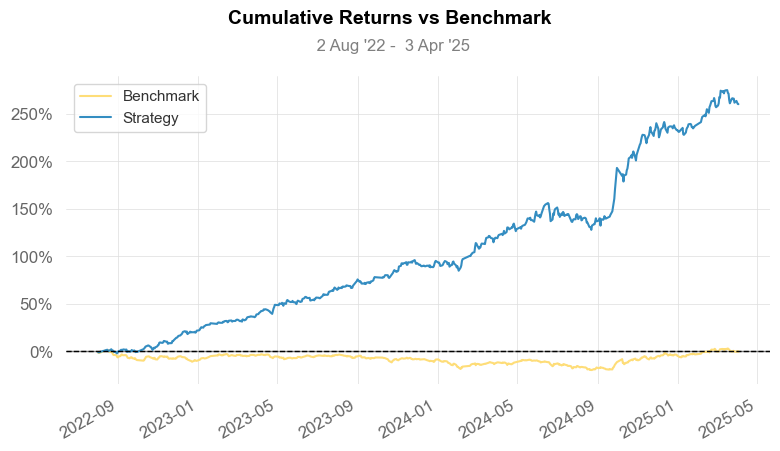

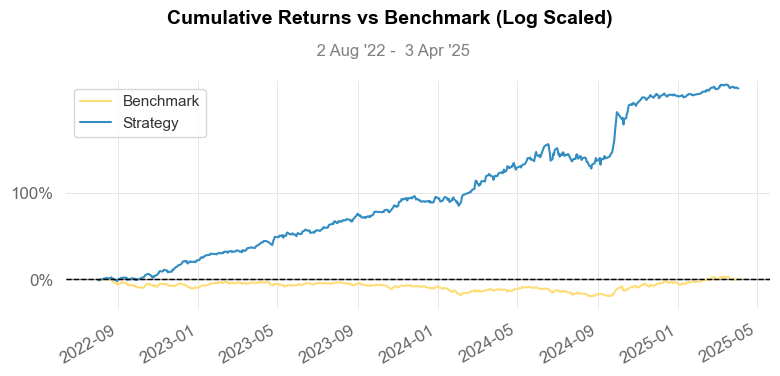

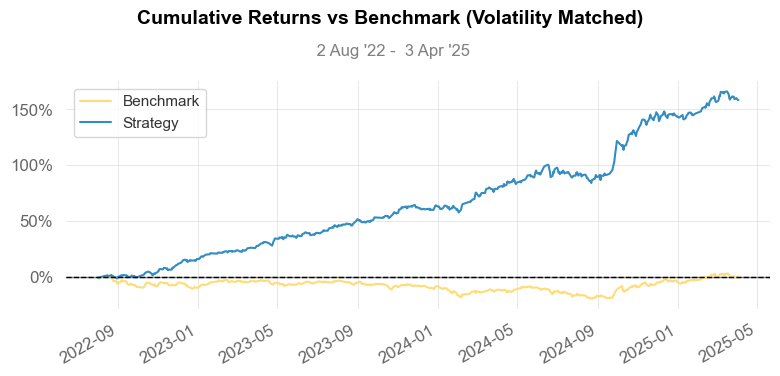

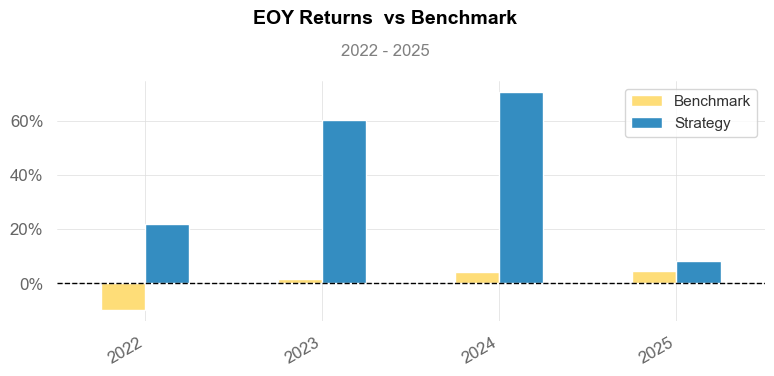

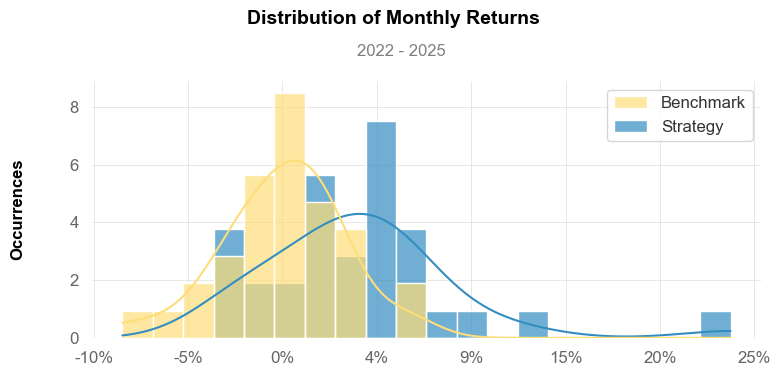

Error generating QuantStats report: numpy operations are not valid with resample. Use .resample(...).sum() instead
--- Report Generation Attempt Complete ---


In [206]:
# 2. Choose a combination (e.g., by index from results_df)
# target_combination_index = 0 # Choose the index (e.g., 0 for the top result if sorted)
# index_df_base = pd.read_parquet('/Users/yiwei/Desktop/git/index.pq') # 导入指数数据
# <<< USER INPUT: Look at the results_df displayed above and enter the index number >>>
selected_combination_index = 0  # <--- CHANGE THIS VALUE

# --- Code to Generate the Report ---

# 1. Check if necessary variables from Cell 1 exist
if ('results_df' in locals() and 'df_filtered' in locals() and 'df_index' in locals() and 'CONFIG' in locals()
    and not results_df.empty and isinstance(selected_combination_index, int)
    and 0 <= selected_combination_index < len(results_df)):

    # 2. Extract the specific weights from the chosen row in results_df
    factor_weight_columns = list(CONFIG['factor_weights_search'].keys())
    weights_dict_for_report = results_df.loc[selected_combination_index, factor_weight_columns].to_dict()

    # 3. Call the helper function using the variables loaded/processed in Cell 1
    #    **** Use df_index directly, DO NOT reload index_df_base ****
    generate_report_for_combination(
        factor_weights_dict=weights_dict_for_report,
        df_filtered_base=df_filtered,    # Use the filtered data from Cell 1
        index_df_base=df_index,          # <--- USE df_index from Cell 1
        config_dict=CONFIG               # Pass the main config from Cell 1
    )

else:
    print(f"Error: Could not generate report. Check the following:")
    if 'results_df' not in locals() or results_df.empty: print(" - 'results_df' not found or is empty. Run the parameter search cell first.")
    if 'df_filtered' not in locals(): print(" - 'df_filtered' not found. Run the parameter search cell first.")
    if 'df_index' not in locals(): print(" - 'df_index' not found. Run the parameter search cell first.")
    if 'CONFIG' not in locals(): print(" - 'CONFIG' not found. Run the parameter search cell first.")
    if 'results_df' in locals() and not (isinstance(selected_combination_index, int) and 0 <= selected_combination_index < len(results_df)):
         print(f" - Index {selected_combination_index} is invalid for results_df with length {len(results_df)}.")

# # ===== IN ANOTHER JUPYTER NOTEBOOK CELL =====

# # Example: Generate detailed report for a specific combination by index
# target_index = 5 # Choose the index from results_df you want to inspect

# if 'results_df' in locals() and not results_df.empty and target_index < len(results_df):

#     factor_weight_columns = list(CONFIG['factor_weights_search'].keys())
#     specific_weights_series = results_df.loc[target_index, factor_weight_columns]
#     weights_for_report = specific_weights_series.to_dict()

#     generate_report_for_combination(
#         factor_weights_dict=weights_for_report,
#         df_filtered_base=df_filtered,
#         index_df_base=df_index,
#         config_dict=CONFIG
#     )
# else:
#      print(f"results_df not found, is empty, or index {target_index} is out of bounds.")


Testing qs.plots.monthly_heatmap...


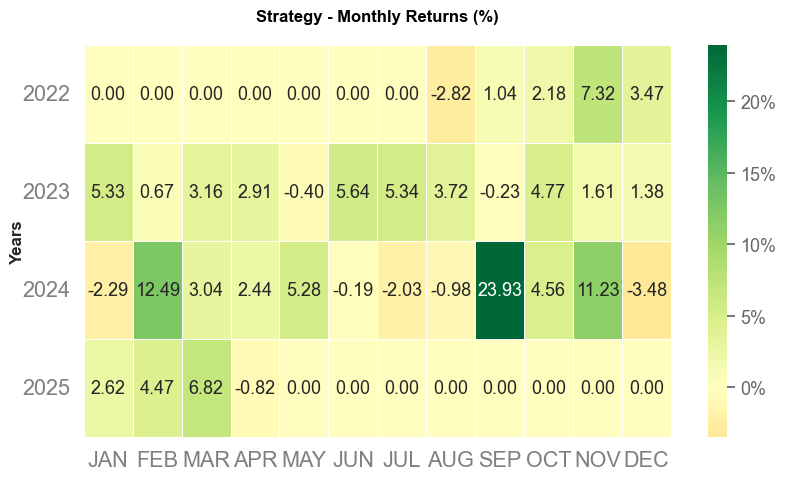

qs.plots.monthly_heatmap SUCCESS (check plot output)


In [199]:
# In a new cell
if 'net_returns' in locals() and net_returns is not None:
    try:
        print("\nTesting qs.plots.monthly_heatmap...")
        qs.plots.monthly_heatmap(net_returns, show=True) # show=True attempts to display
        print(f"qs.plots.monthly_heatmap SUCCESS (check plot output)")
    except Exception as e:
        print(f"qs.plots.monthly_heatmap FAILED: {e}")
else:
    print("net_returns not found.")